In [8]:
####################################################################################
# this code defines function to create edges for specific drainage basin
# edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
####################################################################################

import os
import numpy as np
import json
from collections import defaultdict, deque

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker

##########################################################
# kinshana river basin
# hydrabad=citynum(40)
# 19 cities
riv_num = 64
uid_str = '64.0'
distance = 100
##########################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    new_basin_to_cities = json.load(json_file)
    
def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent
    
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

def is_valid_edge(city1, city2, coords_dict):
    """
    multiple city at 1 coord
    then remove smaller number city at upstream (False)
    """
    for coord, city_list in coords_dict.items():
        if len(city_list) > 1:
            if city1 in city_list and city2 in city_list:
                if city1 > city2:
                    continue
                else:
                    city1, city2 = None, None
                    
    if city1 and city2:
        return True
    else:
        return False
        
def prf_int_flag(prf, intake, riv_num, rivnum_gl5, rivout_gl5):
    # unique coord
    pprf_coord = np.where((prf == 1) & (rivnum_gl5 == riv_num))
    sprf_coord = np.where((prf == 1) & (rivnum_gl5 != riv_num))
    int_coord = np.where((intake == 1) & (rivnum_gl5 == riv_num))
    
    # Create copies of prf and intake to avoid modifying original inputs
    prf_copy = np.copy(prf)
    pprf_copy = np.copy(prf)
    sprf_copy = np.copy(prf)
    intake_copy = np.copy(intake)
    
    # delete
    pprf_copy[sprf_coord] = 0
    sprf_copy[pprf_coord] = 0

    if pprf_coord[0].size != 0 and int_coord[0].size != 0:
        pprf_runout = rivout_gl5[pprf_coord][0] * 60 * 60 * 24 * 365 / 1000
        int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / 1000
        
        if pprf_runout > int_runout:
            print('PRF > intake')
            largest = pprf_copy
            all_int = prf_copy
            flag = 'prf-larger'
        else:
            print('INTAKE > prf')
            largest = intake_copy
            all_int = sprf_copy + intake_copy
            flag = 'intake-larger'
            
    elif pprf_coord[0].size != 0 and int_coord[0].size == 0:
        print('PRF only')
        largest = pprf_copy
        all_int = prf_copy + intake_copy
        flag = 'prf-only'
        
    elif pprf_coord[0].size == 0 and int_coord[0].size != 0:
        print('INTAKE only')
        largest = intake_copy
        all_int = prf_copy + intake_copy
        flag = 'intake-only'
        
    else:
        largest = prf_copy
        all_int = prf_copy
        print('Error: no prf no int')
        flag = 'no-prf-int'

    return flag, largest, all_int, prf_copy

def updown(new_basin_to_cities, uid_str='3.0', distance=100, riv_num=3):
    # get cities in basin
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    print(f'city_list: {city_list}')
    
    # remove overlap
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    print(f'city_list_removed: {city_list_removed}')
    
    # rivnextlonlat 
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
    
    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    # coord of purificication
    coords_a = []
    for city_num in city_list_removed:
        # rivnum
        rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
        rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        # 1. prfとintどちらもが対象領域内(uid_int)でprfが大きい
        # 2. prfとintどちらもが対象領域内(uid_int)でintが大きい
        # 3. prfのみが対象流域内(uid_int)
        # 4. intのみが対象流域内(uid_int)
        uid_int = int(riv_num)
        flag, largest, all_int, prf_copy = prf_int_flag(prf, intake, uid_int, rivnum_gl5, rivout_gl5)
        largest_coord = np.where(largest==1)
        print(f'largest_coord{largest_coord}, city_num: {city_num}, uid_int: {uid_int}')
        coords_a.append([largest_coord, city_num])
        
    ####################################################################################
    # 同流域内で取水点がかぶっている都市を取水点ごとにリストにする
    ####################################################################################

    # 同じ座標に対して city_num のリストを作成するための辞書
    same_coords_dict = defaultdict(list)

    # coords_a の要素をループして座標をキーに city_num をリストに追加
    for coord, city_num in coords_a:
        for i in range(len(coord[0])):
            coord_tuple = (coord[0][i], coord[1][i])
            same_coords_dict[coord_tuple].append(city_num)
            
    ####################################################################################
        
    # down
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    
    # city_num loop 
    for idx in range(len(coords_a)):

        # init
        visited_coords = set()
        
        # upstream
        cityup = coords_a[idx][1]
        
        # coords_a[idx][0] = (array([732]), array([3086]))
        riv_path_array[coords_a[idx][0][0][0], coords_a[idx][0][1][0]] = idx

        # coordinates of prf and intake
        coords_b = coords_a.copy()
        coords_b.pop(idx) 

        # main loop
        if len(coords_a) > 0:
            target_coord = (coords_a[idx][0][0][0], coords_a[idx][0][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = idx
                target_coord = next_coord

        for coord in coords_b:
            citydwn = coord[1]
            
            if coord[0][0].size == 0:
                continue
            else:
                standard_coord = (coord[0][0][0], coord[0][1][0])
                if standard_coord in visited_coords:
                    edge_flag = is_valid_edge(cityup, citydwn, same_coords_dict)
                    print(f'cityup: {cityup}, citydwn: {citydwn}, edge_flag: {edge_flag}')
                    if edge_flag:
                        edges.append((cityup, citydwn))
                    else:
                        continue
                else:
                    continue
                    
    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, city_list_removed
    
def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax
    
#############################################################
# トポロジカルソート
# edgesが必要
#############################################################

def topological_sort(edges):
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    
    return sorted_order

#edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
#sorted_order = topological_sort(edges)
print(f'city_list_removed: {city_list_removed}')
print(f'sorted_order: {sorted_order}')
print(f'coords_a: {coords_a}')

city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
sorted_order: [66, 485, 1255, 40, 778, 894, 852, 1429, 1493, 287, 1758, 1106, 475, 1174, 1000, 708, 314]
coords_a: [[(array([872]), array([3100])), 40], [(array([862]), array([3048])), 66], [(array([851]), array([3049])), 287], [(array([881]), array([3125])), 314], [(array([867]), array([3065])), 475], [(array([886]), array([3054])), 485], [(array([880]), array([3123])), 708], [(array([890]), array([3052])), 778], [(array([876]), array([3053])), 852], [(array([868]), array([3085])), 894], [(array([883]), array([3092])), 1000], [(array([914]), array([3067])), 1106], [(array([896]), array([3076])), 1174], [(array([849]), array([3058])), 1255], [(array([895]), array([3084])), 1429], [(array([914]), array([3067])), 1493], [(array([874]), array([3114])), 1758]]


In [13]:
prf = np.where(tmp==city_num, 1, 0)

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
PRF only
largest_coord(array([872]), array([3100])), city_num: 40, uid_int: 64
INTAKE > prf
largest_coord(array([862]), array([3048])), city_num: 66, uid_int: 64
INTAKE only
largest_coord(array([851]), array([3049])), city_num: 287, uid_int: 64
INTAKE only
largest_coord(array([881]), array([3125])), city_num: 314, uid_int: 64
INTAKE > prf
largest_coord(array([867]), array([3065])), city_num: 475, uid_int: 64
INTAKE > prf
largest_coord(array([886]), array([3054])), city_num: 485, uid_int: 64
INTAKE only
largest_coord(array([880]), array([3123])), city_num: 708, uid_int: 64
INTAKE > prf
largest_coord(array([890]), array([3052])), city_num: 778, uid_int: 64
INTAKE > prf
largest_coord(array([876]), array([3053])), city_num: 852, uid_int: 64
PRF only
largest_coord(array([

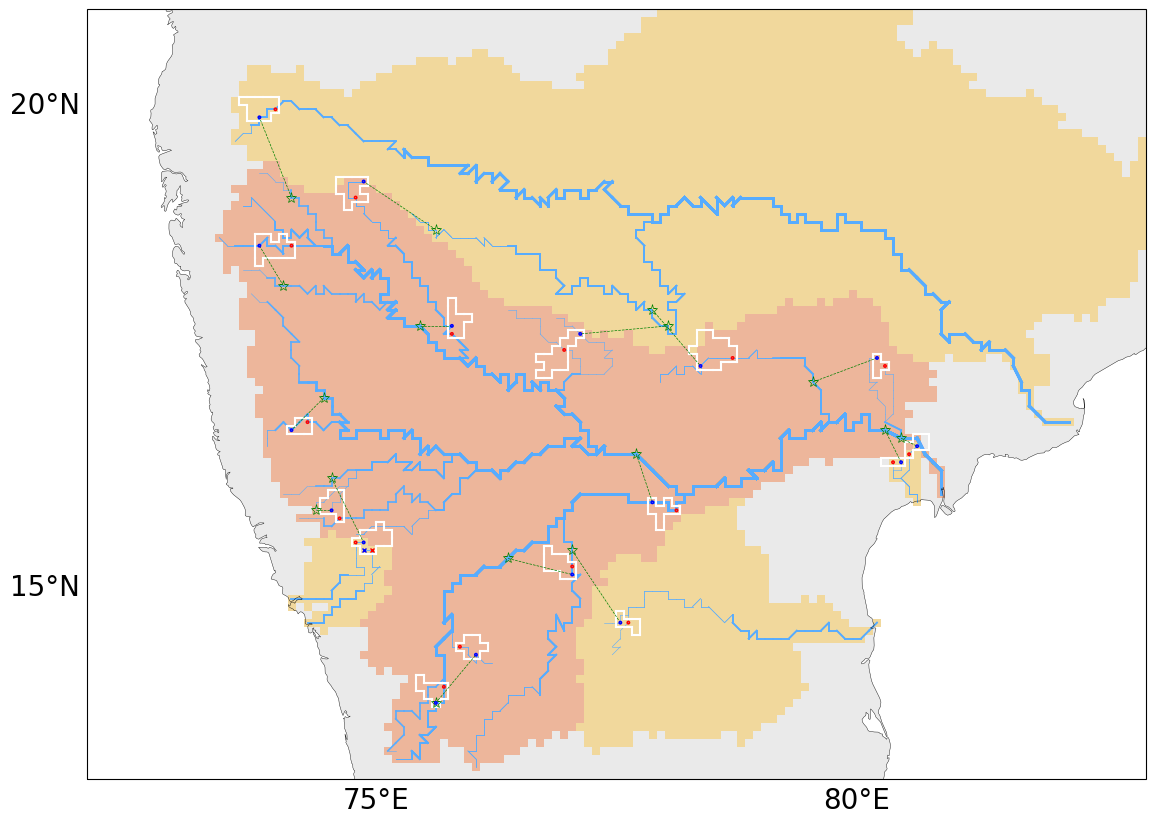

In [16]:
def get_rivpath_all_tmp(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex):
    """riv_num内の全riv_pathとriv_num外のriv_pathのすべてを表示する"""
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    prf_dir = f'{h08dir}/camacity/dat/cty_prf_'
    prf_path = f'{prf_dir}/prf_clrd0000.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    
    swg_dir = f'{h08dir}/camacity/dat/cty_swg_'
    swg_path = f'{swg_dir}/swg_clrd0000.gl5'
    swg = np.fromfile(swg_path, dtype='float32').reshape(2160, 4320)
    
    int_dir = f'{h08dir}/global_city/dat/cty_int_/100km_samebasin'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex]

    # city_numをkeyにしてprfまたはintの下流になるrivpathを保存
    rivpath_dict = {}

    # city loop
    for city_num in sorted_order:
        city_num_dict = {}
        coord_list = []
        
        prf_masked = np.where(prf==city_num, 1, 0)
        swg_masked= np.where(swg==city_num, 1, 0)
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if np.sum(prf_masked) < 1:
            print(f'{city_num} is invalid prf')
            
        else:
            prf_cropped = prf_masked[upperindex:lowerindex, leftindex:rightindex]
            swg_cropped = swg_masked[upperindex:lowerindex, leftindex:rightindex]
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

            coord_list.append(np.where(prf_cropped == 1))
            coord_list.append(np.where(swg_cropped == 1))
            coord_list.append(np.where(intake_cropped == 1))

        # downstream exploration
        count = 0
        for srcd in coord_list:
            yyy = srcd[0]
            xxx = srcd[1]
            for y, x in zip(yyy, xxx):
                target_coord = (y, x) 
            
                path_coords = [target_coord]
                visited_coords = set()
                
                while True:
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    target_row, target_col = target_coord
                    next_coord = riv_nxlonlat_cropped[target_row, target_col]
                    if next_coord.size == 0 or next_coord.shape != (2,):
                        break
                    target_coord = (next_coord[0], next_coord[1])
                    path_coords.append(target_coord)
                city_num_dict[count] = path_coords
                count += 1

        # upstream exploration
        for srcd in coord_list:
            yyy = srcd[0]
            xxx = srcd[1]
            for y, x in zip(yyy, xxx):
                target_coord = (y, x)
                
                path_coords = [target_coord]
                visited_coords = set()

                while True:
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    matched_coords = np.argwhere(
                        np.all(target_coord == riv_nxlonlat_cropped, axis=2)
                    )
                    if len(matched_coords) == 0:
                        break
                    unvisited_matched = [
                        tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords
                    ]
                    if not unvisited_matched:
                        break
                    rivara_values = [
                        rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched
                    ]
                    max_index = np.argmax(rivara_values)
                    best_coord = unvisited_matched[max_index]
                    target_coord = best_coord
                    path_coords.append(target_coord)
                city_num_dict[count] = path_coords
                count += 1
            
        # add dict
        rivpath_dict[city_num] = city_num_dict
    
    return rivpath_dict

def test():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities_100km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    order = city_list_removed
    
    order_index = []
    for cnm in order:
        idx = np.where(np.array(nums) == cnm)[0]
        order_index.append(idx)

    target_lons = lons[order_index]
    target_lats = lats[order_index]
    
    # rivnxl
    path_dict = get_rivpath_all_tmp(riv_num, order, upperindex, lowerindex, leftindex, rightindex)

    ###########################################################################################
    # if there are prf out of uid_int => add pprf_dct as list
    # if abandon prf => add prf to sprf_dct
    # if abandon int(no int) => add None to ibt_dct

    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}
    pswg_dct = {}
    sswg_dct = {}

    sub_rivnum_list = []
    
    prf_dir = f'{h08dir}/camacity/dat/cty_prf_'
    prf_path = f'{prf_dir}/prf_clrd0000.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    
    swg_dir = f'{h08dir}/camacity/dat/cty_swg_'
    swg_path = f'{swg_dir}/swg_clrd0000.gl5'
    swg = np.fromfile(swg_path, dtype='float32').reshape(2160, 4320)
    
    for city_num in order:
    
        # prf
        prf_masked = np.where(prf==city_num, 1, 0)
        prf_cropped = prf_masked[upperindex:lowerindex, leftindex:rightindex]
        
        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

        # swg
        swg_masked= np.where(swg==city_num, 1, 0)
        swg_cropped = swg_masked[upperindex:lowerindex, leftindex:rightindex]

        # swg is followed the existence of prf plant
        # still, if there is no prf, intake will be the reciever area of wastewater treatment plant
        # then swg coordinates should be prepared independently
        
        # 1. pprf: prf in uid
        # 2. sprf: prf not in uid
        # 3. pint: intake in uid
        # 4. sint: intake not in uid
        uid_int = int(riv_num)
        pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
        sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
        pint_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
        sint_coord = np.where((intake_cropped == 1) & (rivnum_cropped != uid_int))
        pswg_coord = np.where((swg_cropped == 1) & (rivnum_cropped == uid_int))
        sswg_coord = np.where((swg_cropped == 1) & (rivnum_cropped != uid_int))
        
        # secondary_rivnum
        sprf_rn = rivnum_cropped[sprf_coord]
        unq_sprf_rn = np.unique(sprf_rn)
        if unq_sprf_rn.size != 0:
            for i in unq_sprf_rn:
                sub_rivnum_list.append(i)
                
        sint_rn = rivnum_cropped[sint_coord]
        unq_sint_rn = np.unique(sint_rn)
        if unq_sint_rn.size != 0:
            for i in unq_sint_rn:
                sub_rivnum_list.append(i)

        # remove no sprf
        if sprf_coord[0].size == 0:
            sprf_coord = None
            
        # remove no sint
        if sint_coord[0].size == 0:
            sint_coord = None

        # remove no sswg
        if sswg_coord[0].size == 0:
            sswg_coord = None
    
        ##############################################################################
        # 1. int or pprf selection
        if pprf_coord[0].size != 0 and pint_coord[0].size != 0:
            prf_runout = rivout_cropped[pprf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_cropped[pint_coord][0] * 60 * 60 * 24 * 365 / (1000)

            # 1.1 pprf selected int abandon
            if prf_runout > int_runout:
                primary_prf_coord = pprf_coord
                primary_swg_coord = pswg_coord
                secondary_prf_coord = sprf_coord
                secondary_swg_coord = sswg_coord
                ibt_coord     = None #pint_coord
                
            # 1.2 int selected pprf abandon
            else:
                if sprf_coord is None:
                    primary_prf_coord = pprf_coord #ほんとはabandonしたいけどsprfがない場合
                    primary_swg_coord = pswg_coord
                    secondary_prf_coord = sprf_coord
                    secondary_swg_coord = sswg_coord
                else:
                    if len(sprf_coord[0]) == 1:
                        primary_prf_coord = sprf_coord
                        primary_swg_coord = sswg_coord
                        secondary_prf_coord = None
                        secondary_swg_coord = None
                    else:
                        primary_prf_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                        primary_swg_coord = (np.array([sswg_coord[0][0]]), np.array([sswg_coord[1][0]]))
                        secondary_prf_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
                        secondary_swg_coord = (np.delete(sswg_coord[0], 0), np.delete(sswg_coord[1], 0))
                    
                ibt_coord = pint_coord

        # 2. pprf only in rivnum
        elif pprf_coord[0].size != 0 and pint_coord[0].size == 0:
            primary_prf_coord = pprf_coord
            primary_swg_coord = pswg_coord
            secondary_prf_coord = sprf_coord
            secondary_swg_coord = sswg_coord
            ibt_coord     = sint_coord

        # 3. int only in rivnum
        elif pprf_coord[0].size == 0 and pint_coord[0].size != 0:
            # 3.1 sprf
            if len(sprf_coord[0]) == 1:
                primary_prf_coord = sprf_coord
                primary_swg_coord = sswg_coord
                secondary_prf_coord = None
                secondary_swg_coord = None
            # 3.2 sprf of first index
            else:
                primary_prf_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                primary_swg_coord = (np.array([sswg_coord[0][0]]), np.array([sswg_coord[1][0]]))
                secondary_prf_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
                secondary_swg_coord = (np.delete(sswg_coord[0], 0), np.delete(sswg_coord[1], 0))
            ibt_coord = pint_coord
            
        else:
            primary_prf_coord = None
            primary_swg_coord = None
            secondary_prf_coord = None
            secondary_swg_coord = None
            ibt_coord = None
            
        #############################################################################f#
            
        pprf_dct[city_num] = primary_prf_coord
        sprf_dct[city_num] = secondary_prf_coord
        pswg_dct[city_num] = primary_swg_coord
        sswg_dct[city_num] = secondary_swg_coord
        ibt_dct[city_num] = ibt_coord
    
    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['blue', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#edb69b'])
    srivnum_cmap = mcolors.ListedColormap(['#f1d89c'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    for city_num in order:
        path_city_dict = path_dict[city_num]
        
        for key, path_coords in path_city_dict.items():
            
            #2つずつのペアに変換
            path_coords_lat = [coord[0] for coord in path_coords]
            path_coords_lon = [coord[1] for coord in path_coords]
            path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
            path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
            
            for lat_coords, lon_coords in path_coords_grouped:
                # dischargeの取得
                discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
                ###########################################################################################
                # discharge criteria
                ###########################################################################################
                if discharge > 1e10:
                    linewidth = 2.0
                elif 1e10 > discharge > 1e9:
                    linewidth = 1.2
                else:
                    linewidth = 0.4
                
                # lat_coordsとlon_coordsの変換
                lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
                
                # ax.plotを使ってプロット
                ax.plot(lon_coords, lat_coords, 
                        markersize=0, linewidth=linewidth, color='#57acff',
                        marker='o', linestyle='-', transform=projection, zorder=1
                       )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=1, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    for srn in sub_rivnum_list:
        srivnum_masked = np.ma.masked_where(rivnum_cropped != srn, rivnum_cropped)
        ax.imshow(srivnum_masked, 
                  alpha=1, cmap=srivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    for city_num in order:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=1.5)
        
    # prf
    pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, s=3, facecolors='none', linewidths=1.1,
            color='blue', transform=ccrs.PlateCarree(), zorder=3)

    # swg
    pswg_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pswg_dct.items()]
    pswg_lon, pswg_lat = zip(*pswg_latlon)
    ax.scatter(pswg_lon, pswg_lat, s=3, facecolors='none', linewidths=1.1,
            color='red', transform=ccrs.PlateCarree(), zorder=3)

    # int
    int_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
        for n, coord in ibt_dct.items()
    ]
    for lon, lat in int_latlon:
        if lon is not None and lat is not None:
            ax.plot(lon, lat, marker='*', color='green', markersize=8, 
                    markerfacecolor='None', markeredgecolor='green', markeredgewidth=0.5,
                    linestyle='None', transform=ccrs.PlateCarree(), zorder=2)

    # arrow
    for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
        if int_latlon[0] is not None and int_latlon[1] is not None:
            start_lon, start_lat = int_latlon[0], int_latlon[1]
            end_lon, end_lat = prf_latlon[0], prf_latlon[1]
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='green', 
                    linestyle='--', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=1)

    # secondary prf
    sprf_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sprf_dct.items()
    ]
    
    for coord_list in sprf_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='blue', markersize=3, 
                        transform=ccrs.PlateCarree(), zorder=2)
                
    # secondary swg
    sswg_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sswg_dct.items()
    ]
    
    for coord_list in sswg_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='red', markersize=3, 
                        transform=ccrs.PlateCarree(), zorder=2)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    west, east, south, north = 72, 83, 13, 21
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(west/10)*10, east, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(round(south/10)*10, north, 5))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)
    
    plt.show()

test()

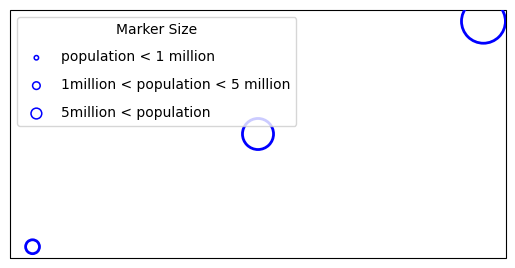

In [10]:
# 凡例を作りたいです

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# プロットするデータ (例)
pprf_lon = [10, 20, 30]
pprf_lat = [50, 55, 60]
pop_size = [100, 500, 1000]  # 例として3つの異なるサイズ

# figureのセットアップ
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# scatter plot
scatter = ax.scatter(pprf_lon, pprf_lat, s=pop_size, facecolors='none', 
                    color='blue', linewidths=2, transform=ccrs.PlateCarree(), zorder=3)

# プロキシアーティストを作成 (凡例用)
# サイズの例 (あなたのデータに合わせて調整)
sizes = [10, 30, 60]
labels = ['population < 1 million', '1million < population < 5 million', '5million < population']

# 凡例の作成
for size, label in zip(sizes, labels):
    plt.scatter([], [], s=size, edgecolor='blue', facecolor='none', linewidths=1.1, label=label)

# 凡例の表示
ax.legend(scatterpoints=1, frameon=True, labelspacing=1, title="Marker Size")

# プロット表示
plt.show()


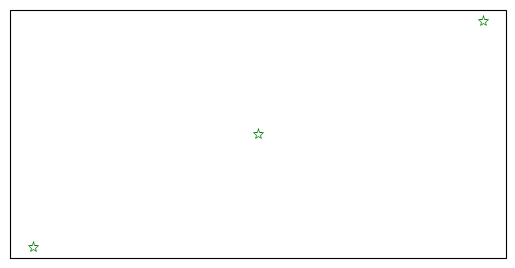

In [11]:
# 凡例を作りたいです

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# プロットするデータ (例)
pprf_lon = [10, 20, 30]
pprf_lat = [50, 55, 60]

# figureのセットアップ
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(pprf_lon, pprf_lat, marker='*', color='green', markersize=8, 
        markerfacecolor='None', markeredgecolor='green', markeredgewidth=0.5,
        linestyle='None', transform=ccrs.PlateCarree(), zorder=2)

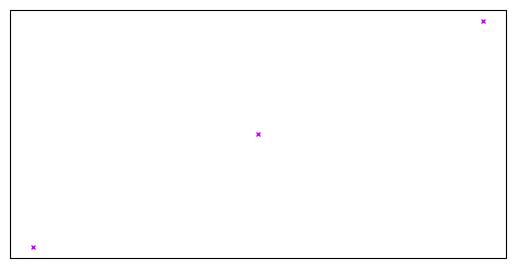

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

pprf_lon = [10, 20, 30]
pprf_lat = [50, 55, 60]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(pprf_lon, pprf_lat, marker='x', color='#c700fe', markersize=3, 
        linestyle='None',
       )